In [2]:
from nltk.lm.preprocessing import pad_both_ends
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from cosine_cost import CosineCost, plot_breakpoints
from discourse import plot_discourse, glyph_bound
from horley_encoding import convert_to_horley

import numpy as np
import os
import re

In [3]:
# Read and preprocess data

with open('data/I.csv', 'r') as file:
    raw_data_I = [line.split(',')[1][:-1] for line in file.readlines()]

# We remove glyph 999 (separator)
clean_lines_I = [line.replace('999', '').replace('.076.', '.076-').split('-') for line in raw_data_I]

encoded_lines_I = [[convert_to_horley(glyph) for glyph in line] for line in clean_lines_I]

In [4]:
# Automatic extraction of the triads by splitting
# whenever we find glyph 076 as an appendage

sequences_I = []

for line in encoded_lines_I:
    i = 0
    j = 1
    while j < len(line):
        if line[j][-3:] == '.76':
            sequences_I.append(line[i:j])
            i = j
        j += 1

# We will add a special token to represent glyph 076
# when appended to the first glyph of the triad

for i in range(len(sequences_I)):
    sequences_I[i][0] = sequences_I[i][0][:-3]
    sequences_I[i].insert(1, '<76>')

sequences_I = [sequence for sequence in sequences_I if len(sequence) >= 4 and sequence[0] and '?' not in sequence]

In [5]:
# Glyphs that most likely precede 076
padded = [list(pad_both_ends(sequence, 2)) for sequence in sequences_I]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<76>' or w[0] == '?')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('600.6', '<76>'), 73.62570510357443),
 (('90', '<76>'), 57.80269539833187),
 (('430', '<76>'), 44.05812049300546),
 (('90.21', '<76>'), 15.028412204819983),
 (('1v', '<76>'), 14.286277582565102),
 (('99', '<76>'), 12.10248546341244),
 (('700', '<76>'), 12.064668887264476),
 (('451', '<76>'), 11.693029235969725),
 (('290.6', '<76>'), 11.263019998192085),
 (('633', '<76>'), 11.081302101755409)]

In [6]:
# Glyphs that most likely follow 076
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[0] != '<76>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('<76>', '11'), 45.31012035527205),
 (('<76>', '532'), 38.77190824754203),
 (('<76>', '71'), 38.41887028612969),
 (('<76>', '70'), 29.654301860701956),
 (('<76>', '10.79f'), 26.358038520561486),
 (('<76>', '4f'), 24.192595897186127),
 (('<76>', '75'), 17.16204074968214),
 (('<76>', '2a.10'), 15.700148271227683),
 (('<76>', '11.2a'), 11.263019998192085),
 (('<76>', '57'), 11.263019998192085)]

In [7]:
# Glyphs that most likely occur as the final
# element in the sequence
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '</s>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('600', '</s>'), 33.30736955146091),
 (('90', '</s>'), 17.49066097925927),
 (('59', '</s>'), 11.081302101755409),
 (('200.10', '</s>'), 8.24948085557606),
 (('27', '</s>'), 8.24948085557606),
 (('670', '</s>'), 7.9096517910893365),
 (('290.2a', '</s>'), 7.503167734931839),
 (('40.290', '</s>'), 7.503167734931839),
 (('513', '</s>'), 7.503167734931839),
 (('59.6', '</s>'), 7.503167734931839)]

In [8]:
trigram_measures = TrigramAssocMeasures()

# Now, let's check for the most likely combinations
# of the first (preceding) and second (following 76) glyphs
finder = TrigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<76>')
finder.score_ngrams(trigram_measures.likelihood_ratio)

[(('600.6', '<76>', '532'), 114.08885469993936),
 (('600.6', '<76>', '70'), 105.73235973666979),
 (('90', '<76>', '11'), 103.93829026685017),
 (('90', '<76>', '71'), 97.5458282225089),
 (('90', '<76>', '70'), 96.77084572730749),
 (('600.6', '<76>', '71.61'), 91.50854903383879),
 (('600.6', '<76>', '600'), 85.5307460601365),
 (('430', '<76>', '532'), 83.40717449315693),
 (('90', '<76>', '2a.10'), 77.00420911780677),
 (('90', '<76>', '57'), 74.40213780403602),
 (('90', '<76>', '5'), 65.68288604817322),
 (('28', '<76>', '11'), 64.64593252962699),
 (('90', '<76>', '700'), 61.032900152803904),
 (('200.10', '<76>', '71'), 58.79413433922902),
 (('1v', '<76>', '71'), 57.961508724467116),
 (('430', '<76>', '770.53'), 56.2375500069417),
 (('430', '<76>', '55'), 56.201399840692076),
 (('99', '<76>', '532'), 55.285452460508324),
 (('99', '<76>', '71'), 53.92920667491693),
 (('381.6', '<76>', '11'), 53.76157544215701),
 (('430', '<76>', '48f'), 53.698773360488445),
 (('430', '<76>', '5'), 53.538917

In [9]:
line_str_I = [' '.join(line) for line in encoded_lines_I]

vectorizer = TfidfVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
vectorized_text = vectorizer.fit_transform(line_str_I)

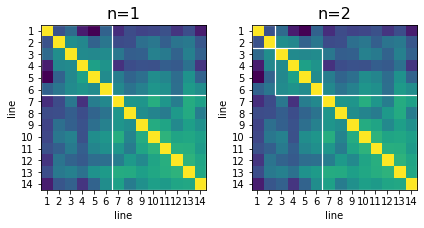

In [10]:
bkpts = plot_breakpoints(vectorized_text, [1, 2])

In [11]:
# Most distinctive glyphs for each segment

feature_names = vectorizer.get_feature_names_out()
X = vectorized_text.toarray()

for bkpt in bkpts:
    indices = [0] + bkpt
    for i in range(len(indices) - 1):
        best_features = np.argmax(X[indices[i]:indices[i+1],:], axis=1)
        print(feature_names[list(set(best_features))])
    print('\n')

['270' '430' '200.6.76' '700.76' '755.76' '76']
['55' '200.10.76' '90.76' '11' '71' '76']


['700.76' '200.6.76']
['755.76' '270' '76' '430']
['55' '200.10.76' '90.76' '11' '71' '76']




In [12]:
full_text = []
for line in encoded_lines_I:
    full_text.extend(line)

In [13]:
first_half = {}
second_half = {}

for glyph in set(full_text):
    if '?' not in glyph and full_text.count(glyph) >= 4:
        bounds = glyph_bound(glyph, encoded_lines_I)
        if bounds[1] < 6:
            first_half[glyph] = bounds
        elif bounds[0] >= 6:
            second_half[glyph] = bounds

# sel_glyphs_ordered = sorted(sel_glyphs.keys(), key=lambda x: sel_glyphs[x][0])
sel_glyphs = sorted(list(first_half)) + sorted(list(second_half))

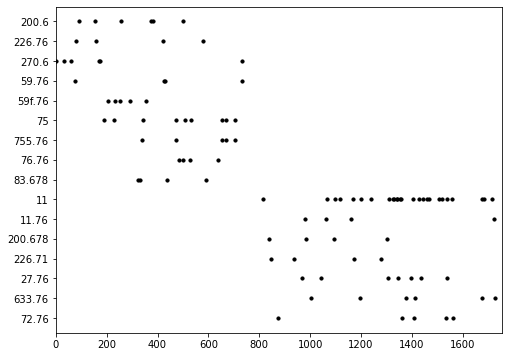

In [14]:
# Distribution of glyphs that appear exclusively
# in the first or second halves

plot_discourse(sel_glyphs, full_text)

In [15]:
common_trigrams = finder.score_ngrams(trigram_measures.likelihood_ratio)

In [16]:
xy_I = [(trigram[0][0], trigram[0][2]) for trigram in common_trigrams]

In [17]:
all_texts = {}

filenames = os.listdir("data/raw_texts/")
for filename in filenames:
    with open(f"data/raw_texts/{filename}", "r") as file:
        lines = file.readlines()
        raw_text = [line.split(',')[1][:-1] for line in lines]
        labels = [line.split(',')[0] for line in lines]
        clean_lines = [line.split('-') for line in raw_text]
        encoded_lines = [[convert_to_horley(glyph) for glyph in line] for line in clean_lines]
        for label, encoded_line in zip(labels, encoded_lines):
            all_texts[label] = ' '.join(encoded_line)

In [18]:
for line in all_texts:
    for pair in xy_I:
        pattern = fr"\b{'(.)'.join(pair)}\b"
        matches = re.findall(pattern, all_texts[line])
        if matches:
            print(line, pair)

Aa2 ('90', '11')
Aa2 ('90', '70')
Aa2 ('27', '95')
Aa5 ('200', '11.2a')
Aa8 ('381.6', '11')
Er7 ('430', '5')
Ev2 ('90', '71')
Sb8 ('90', '70')
Qr7 ('600.6', '600')
Qr7 ('200.10', '71')
Qr7 ('27', '95')
Qv2 ('90', '5')
Hr7 ('600.6', '600')
Hr7 ('27', '95')
Hr11 ('90', '5')
Pr7 ('600.6', '600')
Pr7 ('27', '95')
Pr8 ('600.6', '600')
Pv1 ('90', '5')
Pv7 ('430', '48f')
Cb2 ('600.6', '600')
Ab3 ('430', '5')


In [19]:
def is_similar(a, b):
    a_glyphs = a.split('.')
    b_glyphs = b.split('.')
    if set(a_glyphs) & set(b_glyphs):
        return True
    return False

In [20]:
# sequences where the first and last glyphs are similar
xyx = [seq for seq in sequences_I if is_similar(seq[0], seq[-1])]

# sequences where the first and second glyphs are similar
xxz = [seq for seq in sequences_I if is_similar(seq[0], seq[2])]

# sequences where the second and final glyphs are similar
xyy = [seq for seq in sequences_I if is_similar(seq[2], seq[-1])]

In [21]:
print(len(xyx) / len(sequences_I))
print(len(xxz) / len(sequences_I))
print(len(xyy) / len(sequences_I))

0.05825242718446602
0.045307443365695796
0.025889967637540454


In [22]:
from scipy.stats import poisson

In [23]:
def is_clustered(x):
    tot = sum(line.count(x) for line in encoded_lines_I)
    lam = tot / len(encoded_lines_I)
    res = []
    for i, line in enumerate(encoded_lines_I):
        if line.count(x) > poisson.ppf(0.95, lam):
            res.append(i)
    return res

In [24]:
d = {}

for glyph in set(full_text):
    if '?' not in glyph and full_text.count(glyph) >= 4:
        x = is_clustered(glyph)
        if x:
            d[glyph] = x

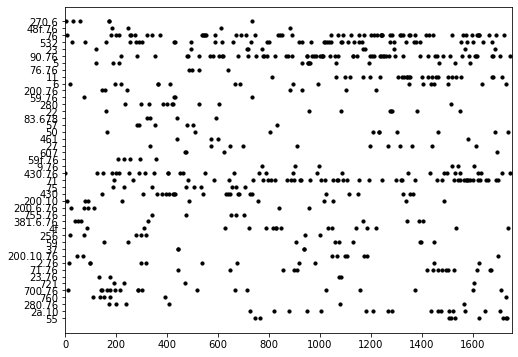

In [25]:
plot_discourse(list(d), full_text)

In [27]:
from scipy.stats import norm

In [108]:
def glyph_indices(glyph, text):
    return [i for i, gl in enumerate(text) if gl == glyph]

def nearest_neighbor_analysis_1d(points, length, alpha=0.05):
    n_points = len(points)
    nearest_distances = np.diff(points)
    observed_mean_distance = np.mean(nearest_distances)
    #expected_mean_distance = length / (n_points + 1)
    rho = n_points / length
    expected_mean_distance = 1 / (2 * rho)
    nnr = observed_mean_distance / expected_mean_distance
    #standard_error = length / ((n_points + 1) * np.sqrt(n_points))
    standard_error = 1 / (2 * rho * np.sqrt(n_points))
    z_score = (observed_mean_distance - expected_mean_distance) / standard_error
    
    if abs(z_score) > norm.ppf(1 - alpha / 2):
        if z_score < 0:
            result = "clustered"
        else:
            result = "dispersed"
    else:
        result = "random"
    
    return z_score, result